# ChargeFW2 Python bindings

This tutorial shows how to use the Python bindings to the ChargeFW2 application, the computation core of Atomic Charge Calculator II (https://acc2.ncbr.muni.cz/).

## Installation

The ChargeFW2 is a C++ application which must be compiled and installed first. See the README: https://github.com/krab1k/ChargeFW2

To use the Python module, it might be necessary to point Python interpreter to the correct library's location. This can be done by setting a PYTHONPATH environment variable. Additionally, we need to specify CHARGEFW2_INSTALL_DIR environment variable so that the library knows how to access its metadata (e.g., pte.csv). Assuming we installed ChargeFW2 into the directory `/opt/chargefw2`, we set:

```bash
export PYTHONPATH=/opt/chargefw2/lib
export CHARGEFW2_INSTALL_DIR=/opt/chargefw2
```

Now we are ready to run Python and use the ChargeFW2 module.

## Usage

First, we import the Python module:

In [1]:
import chargefw2

### Loading the molecules

Then we load the molecules. Supported formats are: SDF, PDB, mmCIF and Mol2. You can also specify the following optional parameters when loading molecules:
```
read_hetatm         Read HETATM records from PDB/mmCIF files 
ignore_water        Discard water molecules from PDB/mmCIF files 
permissive_types    Use similar parameters for similar atom/bond types if no exact match is found
```

In [2]:
molecules = chargefw2.Molecules('molecules.sdf', read_hetatm=True, ignore_water=False, permissive_types=True)

Let's see how many molecules we have loaded:

In [3]:
len(molecules)

47

We can also see additional info:

In [4]:
molecules.info().to_dict()

{'total_molecules': 47,
 'total_atoms': 1531,
 'atom_type_counts': [{'symbol': 'N', 'count': 101},
  {'symbol': 'O', 'count': 118},
  {'symbol': 'C', 'count': 545},
  {'symbol': 'H', 'count': 751},
  {'symbol': 'S', 'count': 16}]}

### Available methods and parameters

ChargeFW2 provides implementation of multiple charge calculation methods. Method is represented by the following c++ struct:

```c++
struct MethodMetadata {
    std::string name;
    std::string internal_name;
    std::string full_name;
    std::optional<std::string> publication;
    std::string type;
    uint16_t priority;
};
```

The full list can be obtained by:

In [5]:
methods = chargefw2.get_available_methods()
[method.internal_name for method in methods]

['sqeqp',
 'eem',
 'abeem',
 'sfkeem',
 'qeq',
 'smpqeq',
 'eqeq',
 'eqeqc',
 'delre',
 'peoe',
 'mpeoe',
 'gdac',
 'sqe',
 'sqeq0',
 'mgc',
 'kcm',
 'denr',
 'tsef',
 'charge2',
 'veem',
 'formal',
 'dummy']

All methods are described in the documentation: https://acc2.ncbr.muni.cz/static/assets/methods.pdf

Some methods require parameters to be set for calculation. They are defined by the following c++ struct:
```cpp
struct ParametersMetadata {
    std::string full_name;
    std::string internal_name;
    std::string method;
    std::string publication;
};
```
To see the list of parameters available for a given method, use:

In [6]:
parameters_list = chargefw2.get_available_parameters('gdac')
[parameters.internal_name for parameters in parameters_list]

['GDAC_00_original']

However, not all methods and parameters can be used for every set of molecules. Applicable combinations can be listed by using the `get_suitable_methods` function. The empty parameter list `[]` denotes that the method does not use parameters:

In [7]:
suitable = chargefw2.get_suitable_methods(molecules)
{ method.internal_name: [params.internal_name for params in parameters_list] for method, parameters_list in suitable }

{'sqeqp': ['SQEqp_10_Schindler2021_CCD_gen'],
 'eem': ['EEM_00_NEEMP_ccd2016_npa',
  'EEM_00_NEEMP_ccd2016_npa2',
  'EEM_05_NEEMP_ccd2016_mpa',
  'EEM_05_NEEMP_ccd2016_mpa2',
  'EEM_10_Cheminf_b3lyp_aim',
  'EEM_10_Cheminf_b3lyp_mpa',
  'EEM_10_Cheminf_b3lyp_npa',
  'EEM_10_Cheminf_hf_aim',
  'EEM_10_Cheminf_hf_mpa',
  'EEM_10_Cheminf_hf_npa',
  'EEM_40_Svob2007_cbeg2',
  'EEM_40_Svob2007_chal2',
  'EEM_40_Svob2007_cmet2',
  'EEM_40_Svob2007_hm2',
  'EEM_60_Ionescu2013_npa_gas',
  'EEM_60_Ionescu2013_npa_pcm',
  'EEM_65_Ionescu2013_mpa_gas',
  'EEM_65_Ionescu2013_mpa_pcm'],
 'qeq': ['QEq_00_original'],
 'eqeq': [],
 'peoe': ['PEOE_00_original'],
 'mpeoe': ['MPEOE_00_original'],
 'gdac': ['GDAC_00_original'],
 'sqe': ['SQE_10_Schindler2021_CCD_gen'],
 'sqeq0': ['SQEq0_10_Schindler2021_CCD_gen'],
 'mgc': [],
 'kcm': ['KCM_00_original'],
 'denr': ['DENR_00_from_QEq'],
 'tsef': ['TSEF_00_from_QEq'],
 'veem': [],
 'formal': [],
 'dummy': []}

You can also find the best parameters for given molecules and method:

In [8]:
best = chargefw2.get_best_parameters(molecules, 'eem')
best.internal_name

'EEM_00_NEEMP_ccd2016_npa'

### Calculating charges

Now, we are ready to calculate the charges. To do this, we use the `calculate_charges` function. It requires set of molecules and a method name with optional parameters name:

In [9]:
help(chargefw2.calculate_charges)

Help on built-in function calculate_charges in module chargefw2:

calculate_charges(...) method of builtins.PyCapsule instance
    calculate_charges(molecules: chargefw2.Molecules, method_name: str, parameters_name: Optional[str] = None, chg_out_dir: Optional[str] = None) -> Dict[str, List[float]]

    Calculate partial atomic charges for a given molecules and method



First, we use EEM with a particular parameter set:

In [10]:
charges_eem = chargefw2.calculate_charges(molecules, 'eem', 'EEM_00_NEEMP_ccd2016_npa')

Second, we can try another method, e.g., SQE+qp: 

In [11]:
charges_sqeqp = chargefw2.calculate_charges(molecules, 'sqeqp', 'SQEqp_10_Schindler2021_CCD_gen')

The type of the results is a dictionary, the keys are the names of the molecules taken from the input file, the values are the list of charges (doubles):

In [12]:
next(iter(charges_sqeqp))

'NSC_100000'

In [13]:
charges_sqeqp['NSC_100000']

[-0.4013101729679659,
 -0.49561754801827207,
 -0.5320169779840946,
 -0.19271326471408015,
 -0.18177030535595046,
 -0.1790840703015261,
 -0.18607445608895054,
 -0.20711936087690122,
 -0.028827174054946152,
 -0.22546219919455587,
 -0.15770951799946373,
 0.16633318542675285,
 -0.08248127574078104,
 -0.18100334661131823,
 -0.16626188101220674,
 0.3955367506629113,
 0.5663927957688,
 -0.17843021301267623,
 0.20252704483948394,
 0.20368248805611636,
 0.20211436774927075,
 0.20923268026389172,
 0.20102006067141365,
 0.21035760217244368,
 0.20756160194174492,
 0.2082682456581313,
 0.2146511589792457,
 0.21343042546931654,
 0.1947733562741633]

Now, we can save the charges to a file:

In [14]:
chargefw2.save_charges(charges_sqeqp, molecules, 'sqeqp', 'SQEqp_10_Schindler2021_CCD_gen', ".")

### (Optional) Plotting the charges

Finally, we can create a simple correlation plot to visually compare the calculated charges:

In [15]:
import matplotlib.pyplot as plt

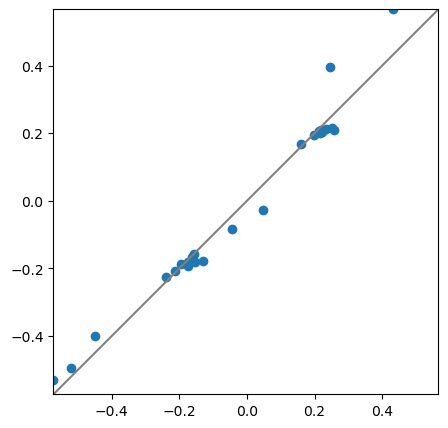

In [16]:
xs = charges_eem['NSC_100000']
ys = charges_sqeqp['NSC_100000']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
low = min(xs + ys)
high = max(xs + ys)
ax.set_xlim(low, high)
ax.set_ylim(low, high)
ax.set_aspect('equal')
ax.plot([low, high], [low, high], c='grey')
ax.scatter(xs, ys)